In [ ]:
from magpie import grasp as gt
import rtde_control
import rtde_receive
from magpie.motor_code import Motors
from magpie import ur5 as ur5
import time
import numpy as np
import copy
import magpie
from magpie.gripper import Gripper
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
from open3d.web_visualizer import draw
import signal

In [ ]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()


In [ ]:
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit = LabelOWLViT(pth=path)

In [ ]:
# indes = []

# def bound():
#     p, rgbd_image = rsc.getPCD()
#     image = np.array(rgbd_image.color)
#     queries = ["a photo of a green block"]
#     abbrevq = ["green_block"]
#     label_vit.set_threshold(0.005)
#     bboxes, uboxes = label_vit.label(image, queries, abbrevq, topk=True, plot=True)

#     bounding_boxes = []
#     for i in range(10):
#         bounding_boxes.append(label_vit.sorted_labeled_boxes_coords[i][0])

#     filtered_boxes = find_similar_boxes(bounding_boxes)

#     objects_of_interest = []

#     for i, group in enumerate(filtered_boxes):
#         for index, box in group:
#             rgbd_image, cpcd, tmat, pcaFrame = pcd.get_segment(
#                 label_vit.sorted_labeled_boxes_coords, 
#                 index, 
#                 rgbd_image, 
#                 rsc, 
#                 type="box-dbscan", 
#                 method="iterative", 
#                 display=False,
#                 viz_scale=1000)
            
#             indes.append(index)
#             area = calculate_area(box)
#             print(f"Group {i}, Index: {index}, Area: {area}")
#             objects_of_interest.append([cpcd, tmat])
            
#     return objects_of_interest

# def calculate_area(box):
#     return abs(box[3] - box[1]) * abs(box[2] - box[0])

# def find_similar_boxes(bounding_boxes, tolerance=0.15, min_count=3):
#     areas = [calculate_area(box) for box in bounding_boxes]
#     similar_groups = []
    
#     for i, area in enumerate(areas):
#         similar_boxes = [(i, bounding_boxes[i])]
#         for j in range(len(areas)):
#             if i != j and abs(areas[j] - area) <= tolerance * area:
#                 similar_boxes.append((j, bounding_boxes[j]))
#             if len(similar_boxes) >= min_count:
#                 break
#         if len(similar_boxes) >= min_count:
#             similar_groups.append(similar_boxes)
#             if len(similar_groups) == 1:
#                 break
    
#     return similar_groups


try:
    self.start()

    while uncertainty < ...
        return objects_of_interest
        for each object:
            self.transofrm
            store object name, segmented pcd, 
            get.center
            

In [ ]:
# ur = ur5.UR5_Interface()
# merged_pcd = o3d.geometry.PointCloud()
# try:
#     ur.start()
#     for pose_num in range(2):
#         boxes = bound()
        

#         # rotation_matrix = np.array([[0, 1, 0, 0],
#         #                         [-1, 0, 0, 0],
#         #                         [0, 0, 1, 0],
#         #                         [0, 0, 0, 1]])

#         # # Transformation matrix for gripper length
#         # tmat_gripper = np.array([[1, 0, 0, -1.15/100],
#         #                         [0, 1, 0, 1.3/100],
#         #                         [0, 0, 1, (309.63 - 195.0)/1000],
#         #                         [0, 0, 0, 1]])

#         # # Get the transformation matrix of the end effector in the base frame

#         # ee_to_base = ur.get_tcp_pose()
#         # average = []
#         # for i in range(len(boxes)):
#         #     print(len(boxes))
#         #     cpcd, tmat= boxes[i]
#         #     cpcd.transform(tmat_gripper)  # Object to end effector frame
#         #     cpcd.transform(rotation_matrix)  # End effector to base frame
#         #     cpcd.transform(ee_to_base)  # End effector to base frame
#         #     center = cpcd.get_center()
#         #     center[2] = center[2] + 233/1000
#         #     average.append(center[2])
#         #     merged_pcd += cpcd
        
#         # average_center = np.mean(average)

#         # target_height= (ee_to_base[2][3] + average_center)*(2/3)

#         # target_pose = ur.get_tcp_pose()
#         # target_pose[2][3] = target_height
        
#         # print(f'The target height is {target_height}')
#         # print(f'Moving robot now to pose {pose_num + 1}')

#         # ur.moveL(target_pose)
#         # time.sleep(3)
#         # time.sleep(3)
#         # #pose_vector = [center[0], center[1], center[2], 3.14, 0, 0]
        
#     ur.stop()

# except Exception as e:
#     ur.stop()
#     raise e


In [ ]:
# ur = ur5.UR5_Interface()
# try:
#     ur.start()
#     #load numpy home pose matrix
#     home = np.load("home_pose.npy")
#     ur.moveL(home)
#     print(ur.get_tcp_pose())
#     time.sleep(3)
#     time.sleep(3)
#     ur.stop()
#     print("Robot moved to home pose")
# except Exception as e:
#     ur.stop()
#     raise e

In [ ]:
# o3d.visualization.draw_geometries([merged_pcd])

In [ ]:
def handler(signum, frame):
    raise Exception("Task took too long")

In [18]:
temp = None
class Perception:
    def __init__(self, num_blocks, query, abbrevq):
        self.ur = ur5.UR5_Interface()
        self.merged_pcd = o3d.geometry.PointCloud()
        self.query = query
        self.abbrevq = abbrevq
        self.blocks = num_blocks
        self.sleep_rate = 3
        self.single_query = True
        self.object_pcd = {}
        
        
    def start_interface(self):
        self.ur.start()

    def stop_interface(self):
        self.ur.stop()

    def open_gripper(self):
        self.ur.open_gripper()

    def close_gripper(self):
        self.ur.close_gripper()

    def move_to_pose(self, pose):
        self.ur.moveL(pose)
        time.sleep(self.sleep_rate)
        time.sleep(self.sleep_rate)


    def get_pose(self):
        return self.ur.get_tcp_pose()
    
    def transform_point_cloud(self, cpcd):
        rotation_matrix = np.array([[0, 1, 0, 0],
                                    [-1, 0, 0, 0],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]])

        tmat_gripper = np.array([[1, 0, 0, -1.15 / 100],
                                 [0, 1, 0, 1.3 / 100],
                                 [0, 0, 1, (309.63 - 195.0) / 1000],
                                 [0, 0, 0, 1]])

        cpcd.transform(tmat_gripper)
        cpcd.transform(rotation_matrix)
        cpcd.transform(self.get_pose())

        return cpcd
    
    def save_point_cloud(self, filename, point_cloud):
         o3d.io.write_point_cloud(filename, point_cloud)

    def save_pose(self, filename, pose):
        np.save(filename, pose)
    
    def load_pose(self, filename):
        return np.load(filename)
    
    def return_to_home(self):
        home = np.load("home_pose.npy")
        self.move_to_pose(home)

    def visualize_point_cloud(self, point_cloud):
        o3d.visualization.draw_geometries([point_cloud])
    
    def calculate_area(self, box):
        return abs(box[3] - box[1]) * abs(box[2] - box[0])
    
    def find_similar_boxes(self, bounding_boxes, tolerance=1):

        areas = [self.calculate_area(box) for box in bounding_boxes]
        similar_groups = []
        
        for i, area in enumerate(areas):

            similar_boxes = [(i, bounding_boxes[i])]
            for j in range(len(areas)):
                if i != j and abs(areas[j] - area) <= tolerance * area:
                    similar_boxes.append((j, bounding_boxes[j]))
                if len(similar_boxes) >= self.blocks:
                    break
            if len(similar_boxes) >= self.blocks:
                similar_groups.append(similar_boxes)
                if len(similar_groups) == 1:
                    break
        
        if not similar_groups:
            raise ValueError(f"No group with at least {self.blocks} similar areas found.")
                    
        
        return similar_groups
    

    def bound(self, query, abbrevq, use_area_calculation=True):

        p, rgbd_image = rsc.getPCD()
        #crop rgbd image

        
        image = np.array(rgbd_image.color)
        label_vit.set_threshold(0.005)
        label_vit.TOP_K = 10
        bboxes, uboxes, scores, labels= label_vit.label(image, query, abbrevq, topk=True, plot=True)
        #sort scores in descending order 
        scores = sorted(scores, reverse=True)

        objects_of_interest = []
        bounding_boxes = []
        
        slbc = label_vit.sorted_labeled_boxes_coords

        for i in range(3):
            # bounding_boxes.append(label_vit.sorted_labeled_boxes_coords[i][0])
            bounding_boxes.append(slbc[i][0])


        if use_area_calculation:
            filtered_boxes = self.find_similar_boxes(bounding_boxes)
            for i, group in enumerate(filtered_boxes):
                for index, box in group:
                    
                    try:
                        cpcd, tmat = self.segment(index, rgbd_image)
                        objects_of_interest.append([cpcd, tmat])
                    except Exception as e:
                        print("Caught TimeoutError:", e)

        return objects_of_interest
   
    
    def segment(self, index, rgbd_image):

        rgbd_image, cpcd, tmat, pcaFrame = pcd.get_segment(
                    label_vit.sorted_labeled_boxes_coords, 
                    index, 
                    rgbd_image, 
                    rsc, 
                    type="box", 
                    method="iterative", 
                    display=False,
                    viz_scale=1000)
        
        return cpcd, tmat
    
    def calculate_probability_dist(self, data, scores):
        probability = {}
        locations = self.find_all_occurrences(data)
        
        # Ensure temp is a list of the same length as self.blocks
        temp = [0] * self.blocks
        
        for i in range(self.blocks):
            sum_scores = 0
            for j in range(len(locations[i])):
                sum_scores += scores[locations[i][j]]
            
            if sum_scores == 0:
                temp[i] = 0
            else:
                temp[i] = scores[locations[i][0]] / sum_scores
        
        # Calculate softmax probabilities
        exp_temp = np.exp(temp)
        softmax = exp_temp / np.sum(exp_temp)
        
        for i in range(self.blocks):  
            probability[self.abbrevq[i]] = softmax[i]
        return probability


    
    def find_all_occurrences(self, data):
        # Initialize a dictionary to store lists of occurrences
        all_occurrences = {obj: [] for obj in range(self.blocks)}
        
        # Iterate through the list and find all occurrences
        print('Initial all_occurrences:', all_occurrences)

        for index, (_, value) in enumerate(data):
            all_occurrences[value].append(index)
        
        print('Final all_occurrences:', all_occurrences)

        return all_occurrences

            
        
    def build_model(self, n):
        try:
            self.start_interface()
            #self.return_to_home()

            for i in range(n):
                if self.single_query:
                    boxes = self.bound(self.query, self.abbrevq)
                    for cpcd, tmat in boxes:
                        cpcd = self.transform_point_cloud(cpcd)


                else:
                    for j in range(len(self.query)):
                        boxes = self.bound(self.query[j], self.abbrevq[j])
                        for cpcd, tmat in boxes:
                            cpcd = self.transform_point_cloud(cpcd)
                            #self.temp_pcd[self.abbrevq[j]][f'Pose {i+1}'] = [cpcd, tmat, score]
                            #temp = self.temp_pcd
                            #print(temp)
        
            
            self.stop_interface()
        except Exception as e:
            self.stop_interface()
            raise e
        
    

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
Plot box
slbc [(array([  59.895,    2.22 , 1278.428,  719.934]), 1), (array([622.016, 171.383, 687.657, 237.09 ]), 2), (array([512.236, 371.521, 586.448, 440.541]), 1), (array([765.021, 287.795, 852.73 , 370.699]), 0), (array([137.568,   4.983, 249.695, 722.634]), 1), (array([ 192.324,    2.367, 1094.101,  719.39 ]), 2), (array([2.222e+00, 1.049e-01, 1.450e+02, 7.183e+02]), 1), (array([ 372.82 ,  379.222, 1015.793,  724.359]), 1), (array([511.705, 374.517, 584.565, 439.502]), 1), (array([766.63 , 290.437, 853.789, 372.229]), 0), (array([ 937.835,    3.69 , 1287.09 ,  721.658]), 1), (array([ 6.675e+02, -7.579e-02,  7.782e+02,  1.342e+01]), 2)]
Initial all_occurrences: {0: [], 1: [], 2: []}
Final all_occurrences: {0: [3, 9], 1: [0, 2, 4, 6, 7, 8, 10], 2: [1, 5, 11]}
locations {0: [3, 9], 1: [0, 2, 4, 6, 7, 8, 10], 2: [1, 5, 11]}
{'purple': 0.396382346018

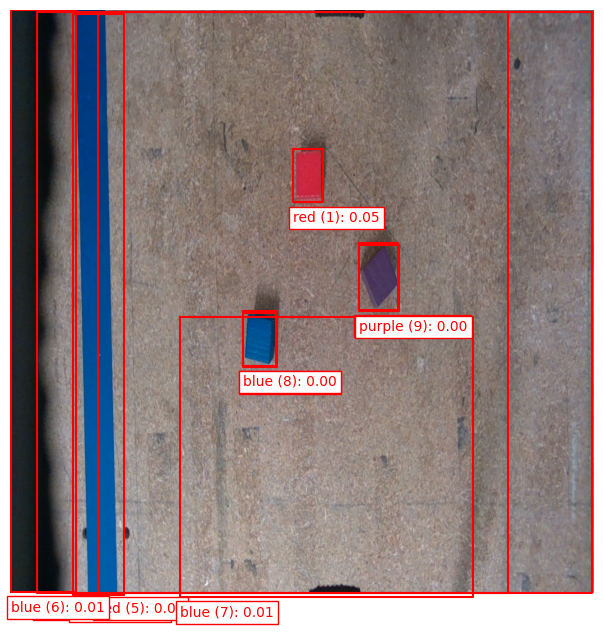

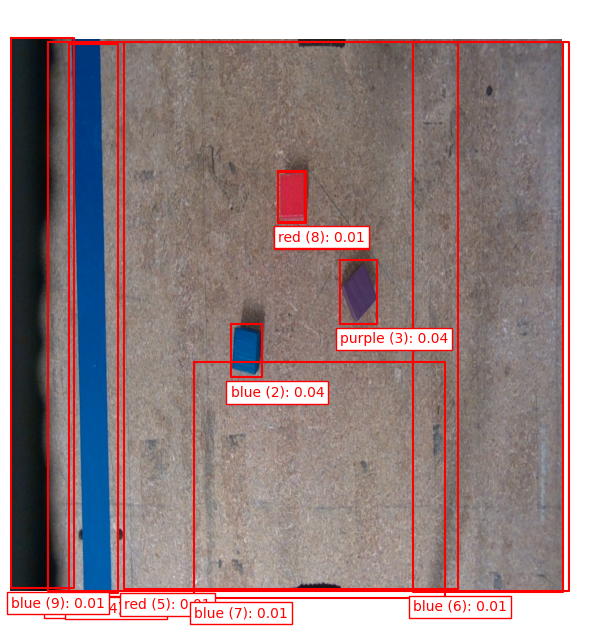

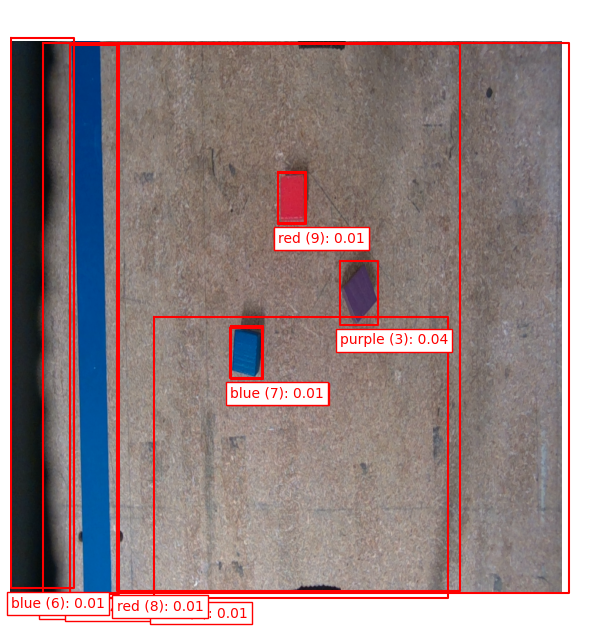

In [19]:
queries = ["a photo of a purple block", "a photo of a blue block", "a photo of a red block"]
abbrevq = ["purple", "blue", "red"]
num_blocks = 3
iterations_per_pose = 3

tower = Perception(num_blocks, queries, abbrevq)
tower.build_model(iterations_per_pose)

In [ ]:
# #load pcd file and visualize
# ppcd = o3d.io.read_point_cloud("merged_pcd.pcd")
# o3d.visualization.draw_geometries([ppcd])

In [ ]:

        # scores = []
        # p, rgbd_image = rsc.getPCD()
        # image = np.array(rgbd_image.color)
        # label_vit.set_threshold(0.005)
        # print("Labeling image...")
        # try:
        #     bboxes, uboxes, scores = label_vit.label(image, query, abbrevq, topk=True, plot=True)
        #     print("Image labeled")
        #     signal.alarm(0)
        # except TimeoutError as e:
        #             print("Caught TimeoutError:", e)
                    
        # scores = sorted(scores, reverse=True)
        # objects_of_interest = []
        # bounding_boxes = []
        # for i in range(5):
        #     bounding_boxes.append(label_vit.sorted_labeled_boxes_coords[i][0])

        # if use_area_calculation:
        #     filtered_boxes = self.find_similar_boxes(bounding_boxes)
        #     for i, group in enumerate(filtered_boxes):
        #         for index, box in group:
                    
        #             try:
        #                 print("Starting segment operation...")
        #                 cpcd, tmat = self.segment(index, rgbd_image)
        #                 objects_of_interest.append([cpcd, tmat, scores[index]])
        #                 print("Segment operation completed")
        #             except Exception as e:
        #                 print("Caught TimeoutError:", e)
                   
        # else:  
        #     filtered_boxes = bounding_boxes[:self.blocks]
        #     for i, group in enumerate(filtered_boxes):
        #         for box in group:
        #             try:
        #                 print("Starting segment operation...")
        #                 cpcd, tmat = self.segment(index, rgbd_image)
        #                 objects_of_interest.append([cpcd, tmat, scores[index]])
        #                 print("Segment operation completed")
        #             except Exception as e:
        #                 print("Caught TimeoutError:", e)
                        
                    

        # return objects_of_interest


#self.temp_pcd[f'Pose {n}'][f'Object {i}'] = [cpcd, tmat, scores[index]]

In [ ]:
# queries = ["a photo of a purple block", "a photo of a blue block", "a photo of a red block"]
# abbrevq = ["purple","blue", "red"]

    
# def bound_test(queries, abbrevq):
#     p, rgbd_image = rsc.getPCD()
#     image = np.array(rgbd_image.color)
#     label_vit.set_threshold(0.005)
#     bboxes, uboxes, scores = label_vit.label(image, queries, abbrevq, topk=True, plot=True)
#     #sort scores in descending order 
#     scores = sorted(scores, reverse=True)
#     print(scores[:5])
    
   
# for i in range(3):
#     bound_test(queries[i], abbrevq[i])


       

In [ ]:
# ur5 = ur5.UR5_Interface()
# try:    
#     ur5.start()
#     ur5.stop()
# except Exception as e:
#     ur5.stop()
#     raise e